# Прогноз стоимости автомобилей

## Цель проекта

Необходимо построить модель, позволяющую прогнозировать рыночную стоимость автомобиля в зависимости от его состояния и технических характеристик. Модель планируется использовать для сервиса по продаже автомобилей с пробегом. По условиям технического задания, для выбора оптимальной модели важны следующие характеристики:

- качество предсказания (*RMSE* не больше 2 500);
- скорость предсказания;
- время обучения.

Для реализации поставленной задачи необходимо:
- проанализировать предоставленные исходные данные и их качество (полнота, наличие выбросов и т.п.);
- по возможности устранить выявленные проблемы в данных, подготовить выборки;
- обучить несколько моделей разной степени сложности;
- сравнить модели по означенным характеристикам, выбрать оптимальную;
- проверить качество выбранной модели на тестовой выборке.

In [1]:
#!pip install skimpy
# Импорт используемых библиотек: 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimpy import clean_columns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from warnings import filterwarnings

## Подготовка данных

### Первичный обзор

In [2]:
# Первичный обзор данных:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('datasets/autos.csv')
df.info()
display(df.head())

# Для контроля размера выборки:
init_size = df.shape[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Датасет содержит ок. 354 тыс. объектов. Целевым признаком является `Price` - цена автомобиля, указанная в объявлении. В составе признаков присутствуют следующие данные:
- описание автомобиля - марка и модель, год и месяц регистрации, пробег, информация о ремонтах;
- технические характеристики автомобиля - тип кузова, коробки передач, топлива, мощность двигателя;
- информация об анкете и пользователе - даты создания и скачивания анкеты, число фотографий, почтовый индекс пользователя и дата его последней активности.

Заметим, что колонки названы с большой буквы и без пробелов. Для дальнейшего удобства приведем написание названий признаков к snake_case: 

In [3]:
#filterwarnings('ignore')
# Приведем названия колонок к snake_case:
df = clean_columns(df)
print('Новые названия колонок:\n', list(df.columns))

16 column names have been cleaned

Новые названия колонок:
 ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand', 'repaired', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen']


В части признаков есть пропущенные значения:

In [4]:
# Доли явных пропусков в данных:
pd.DataFrame(round(df.isna().mean()*100,3)).style.background_gradient()

,0
date_crawled,0.000000
price,0.000000
vehicle_type,10.579000
registration_year,0.000000
gearbox,5.597000
power,0.000000
model,5.561000
kilometer,0.000000
registration_month,0.000000
fuel_type,9.283000


Явные пропуски в целевом признаке отсутствуют. Наибольшее число пропусков (более 20%) содержатся в признаке `repaired` (был ли ремонт), ок. 10% - в признаках `vehicle_type` и `fuel_type` (тип кузова и топлива), ок. 6% - в признаках `gearbox` и `model` (тип коробки передач и модель авто). При подготовке данных необходимо будет проанализировать пропущенные значения и по возможности предложить замену пропускам.

### Структура данных

Рассмотрим структуру признаков на предмет подозрительных значений и дубликатов для категориальных признаков.

In [5]:
# Для удобства создадим шаблон для вывода долей:
def shares_display(col_name):
    return (pd.DataFrame(df[col_name].value_counts(normalize=True, dropna=False)).
            rename({col_name:'Доля, %'}, axis=1).
            head(10)*100)

#### Цена автомобилей

C:\Users\1\AppData\Local\Temp\ipykernel_1080\4114479380.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

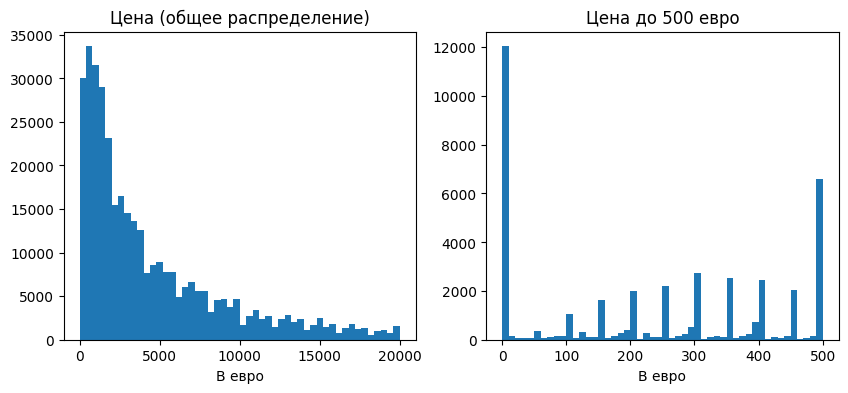

In [6]:
# Гистограмма:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(df['price'], bins = 50)
axs[0].set_title('Цена (общее распределение)')
axs[0].set_xlabel('В евро')
axs[1].hist(df.query('price <= 500')['price'], bins = 50)
axs[1].set_xlabel('В евро')
axs[1].set_title('Цена до 500 евро')
fig.show()
# Описательные статистики:
display(df['price'].describe())

Указанные в объявлениях цены на авто варьируются от 0 до 20 тыс. евро. Распределение смещенное: медиана составляет 2 700 евро, в то время как среднее - ок. 4 400 евро. Присутствует подозрительный пик в районе нуля: цена от 0 до 1 евро указана для 3,4% объектов в выборке.

#### Описание автомобиля

In [7]:
# Описание признака марки авто:
print('Уникальных марок автомобилей:', df['brand'].nunique())
print('Топ-10 марок:')
display(shares_display('brand'))

Уникальных марок автомобилей: 40
Топ-10 марок:


,"Доля, %"
volkswagen,21.732431
opel,11.268198
bmw,10.416825
mercedes_benz,9.043116
audi,8.312240
ford,7.105305
renault,5.058851
peugeot,3.103545
fiat,2.721175
seat,1.949098


- **Марка**: заметим, что выборка достаточно концентрированная: на топ-5 брендов из 40 представленных приходится более 60% всех объектов. Кроме того, все топ-5 брендов имеют немецкое происхождение (вероятнее всего, данные представлены по немецкому рынку).

In [8]:
# Описание признака модели авто:
print('Уникальных моделей автомобилей:', df['model'].nunique())
print(np.sort(df['model'].dropna().unique())) # исключаем пропуски, чтобы отсортировать значения

Уникальных моделей автомобилей: 250
['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour' 'fortwo' 'fox' 'freelander' 'fusion' 'g_klasse' 'galant'
 'galaxy' 'getz' 'gl' 'glk' 'golf' 'grand'

- **Модель**: в выборке представлено 250 уникальных моделей авто; дубликатов в написании не выявлено.

C:\Users\1\AppData\Local\Temp\ipykernel_1080\3661203689.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


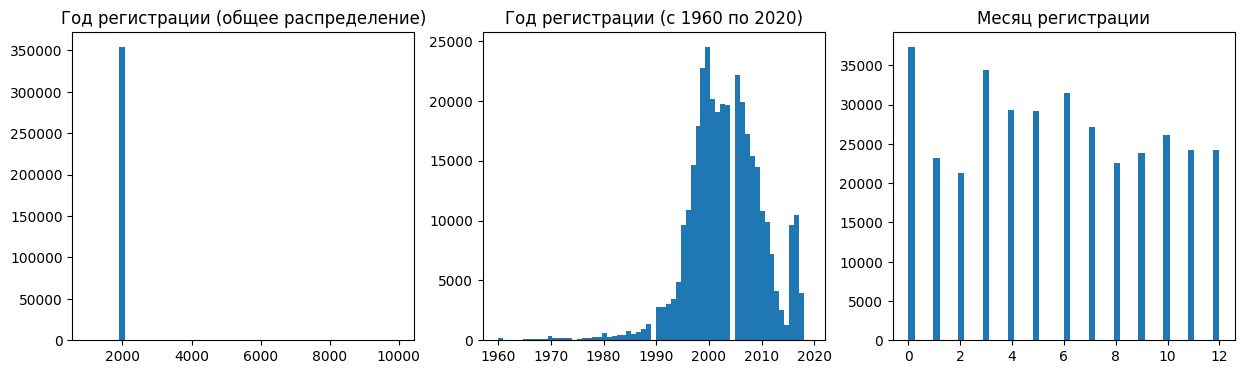

In [9]:
# Описание признаков года и месяца регистрации:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].hist(df['registration_year'], bins = 50)
axs[0].set_title('Год регистрации (общее распределение)')
axs[1].hist(df.query('1960 <= registration_year <= 2022')['registration_year'], bins = 63)
axs[1].set_title('Год регистрации (c 1960 по 2020)')
axs[2].hist(df['registration_month'], bins = 50)
axs[2].set_title('Месяц регистрации')
fig.show()

- **Год регистрации**: в распределении присутствуют единичные выбросы, сдвигающие ось гистограммы и затрудняющие анализ. Такие данные не выглядят правдоподобно: год может быть как меньше 1900, так и больше 2022 гг. Число таких объектов не превышает 0.1% от всей выборки. Диапазон "правдоподобных" значений начинается в 1960 г. и заканчивается 2019 г. Преобладают объекты, зарегистрированные в конце 90-х - начале нулевывх годов. При этом присутствует всплеск на уровне 2016-2018 гг.

Исходя из этого, можно предположить, что под годом регистрации понимается год выпуска автомобиля. Если это так, данный параметр следует учитывать в модели. Однако, если под годом регистрации понимается год последнего перехода права собственности на автомобиль (и соответственно изменений в регистрационных данных), этот параметр в меньшей степени влияет на цену авто.

- **Месяц регистрации**: в ок. 10% данных указан 0 в качестве месяца регистрации. Судя по тому, что также присутствуют объекты с месяцами 1-12, нулем могут быть обозначены объекты, в которых месяц регистрации не указан. Представляется, что месяц регистрации является не принципиальным параметром для расчета цены автомобиля (большее значение имеет год выпуска).

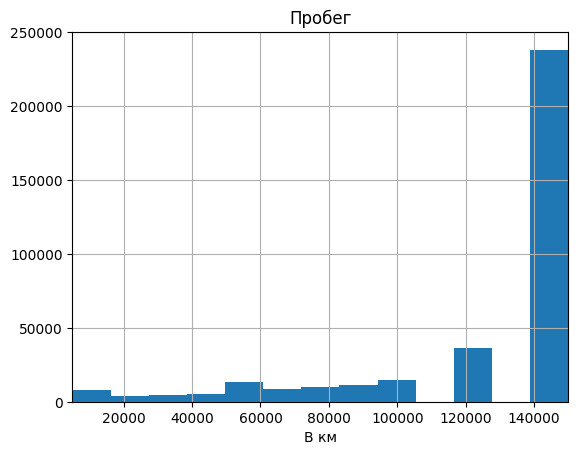

In [10]:
# Описание признака пробега:
df['kilometer'].hist(bins=13)
plt.title('Пробег')
plt.xlim(5000, 150000)
plt.xlabel('В км')
plt.show()

- **Пробег**: заметим, что распределение значений пробега дискретное - всего 13 уникальных значений (5, 10, 20, ..., 100, 125 и 150 тыс. км), причем более 50% объектов обладают пробегом 150 000 км. Такое распределение для реального пробега не выглядит реалистичным; вероятнее всего, анкета предполагает указание *диапазона*, в который попадает реальный пробег авто. При выгрузке указывается максимальное значение диапазона (для диапазона "150 тыс. км +" - минимальное). Т.е. де-факто пробег является категориальным признаком.

In [11]:
# Описание признака ремонта:
print('Структура данных по ремонтам:')
display(shares_display('repaired'))

Структура данных по ремонтам:


,"Доля, %"
no,69.746789
NaN,20.079070
yes,10.174141


- **Ремонт**: ок. 70% объектов во всей выборке не подвергались ремонтам; в 10% - ремонт был; по ок. 20% объектов отсутствуют данные. Скорее всего, они не были указаны в анкете. Однако, наличие пропуска при выгрузке свидетельствует против того, что незаполненные поля при выгрузке превращаются в ноль. Возможно, произошел технический сбой при выгрузке.

#### Технические характеристики автомобиля

In [12]:
# Описание признака типа кузова:
print('Структура данных по типам кузова:')
display(shares_display('vehicle_type'))

Структура данных по типам кузова:


,"Доля, %"
sedan,25.808409
small,22.527648
wagon,18.389306
NaN,10.579368
bus,8.120067
convertible,5.701119
coupe,4.561065
suv,3.385172
other,0.927846


- **Тип кузова**: в выборке доминируют седаны (более 25% общего числа объектов) и мини-автомобили (ок. 23%). В ок. 10% случаев тип кузова не указан. Возможно, получится восстановить информацию по модели авто.

In [13]:
# Описание признака коробки передач:
print('Структура данных по коробке передач:')
display(shares_display('gearbox'))

Структура данных по коробке передач:


,"Доля, %"
manual,75.698213
auto,18.705079
NaN,5.596709


- **Коробка передач**: более 75% автомобилей в выборке имеют механическую коробку передач. Пропуски составляют ок. 6% от всей выборки. Восстановление данных по модели авто в данном случае предстваляется менее оправданным (одна и та же модель может быть оснащена как механической, так и автоматической коробкой передач).

In [14]:
# Описание признака используемого топлива:
print('Структура данных по потребляемому топливу:')
display(shares_display('fuel_type'))

Структура данных по потребляемому топливу:


,"Доля, %"
petrol,61.052744
gasoline,27.857967
NaN,9.282697
lpg,1.498438
cng,0.159438
hybrid,0.065751
other,0.057567
electric,0.025397


- **Тип топлива**: заметим, что термины `petrol` и `gasoline` оба обозначают бензиновое топливо, разница является исключительно лингвистической. Т.е. выявлены неявные дубликаты, которые нужно будет устранить. С учетом этого, бензиновые авто составляют ок. 89% в выборке . На газе (сжатом или сжиженном) работают ок. 1,7% автомобилей в выборке. Доли прочих видов топлива ничтожны. В ок. 10% объектов тип топлива не указан. Поскольку бензин все еще является "топливом по умолчанию", будет оправдано заменить пропуски этим значением.

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

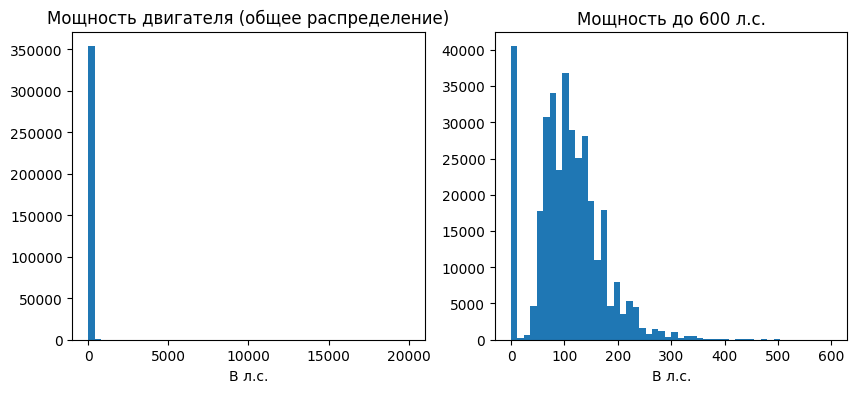

In [15]:
# Описание признака мощности двигателя:
display(df['power'].describe())
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].hist(df['power'], bins = 50)
axs[0].set_title('Мощность двигателя (общее распределение)')
axs[0].set_xlabel('В л.с.')
axs[1].hist(df.query('power <= 600')['power'], bins = 50)
axs[1].set_xlabel('В л.с.')
axs[1].set_title('Мощность до 600 л.с.')
plt.show()

- **Мощность двигателя**: в выборке присутствуют как нулевые значения (ок. 11% выборки), так и единичные экстремально большие значения (более 600 л.с. - ок. 0.1% от выборки). Возможно, нулевое значение мощности означает, что пользователь не заполнил эту информацию в анкете. В таком случае следует расценивать 0 как пропуск и по возможности заменить аналогичным по модели значением.

#### Информация об анкете и пользователе

Рассмотрим даты скачивания анкет, создания объявления и последней активности пользователя. Сами по себе эти данные не влияют на цену автомобиля, однако, возможно, их анализ приведет к каким-либо существенным выводам:

In [16]:
# Переводим даты в удобный формат:
df['date_crawled'] = pd.to_datetime(df['date_crawled'])
df['date_created'] = pd.to_datetime(df['date_created'])
df['last_seen'] = pd.to_datetime(df['last_seen'])

print('Годы скачивания анкет:', df['date_crawled'].dt.year.unique())
print('Месяцы скачивания анкет:', df['date_crawled'].dt.month.unique())
print('-------------')
print('Годы создания анкет:', df['date_created'].dt.year.unique())
print('Месяцы создания анкет:', df['date_created'].dt.month.unique())
print('-------------')
print('Годы последней активности:', df['last_seen'].dt.year.unique())
print('Месяцы последней активности:', df['last_seen'].dt.month.unique())

Годы скачивания анкет: [2016]
Месяцы скачивания анкет: [3 4]
-------------
Годы создания анкет: [2016 2015 2014]
Месяцы создания анкет: [ 3  4  2  1 11 12  9  8  6]
-------------
Годы последней активности: [2016]
Месяцы последней активности: [4 3]


- Видим, что анкеты создавались на протяжении трех лет. Однако последняя активнось пользователей была в то же время, что и скачивание анкет из базы. Т.е., скорее всего, динамика цен на автомобили за время экспозиции анкет уже учтена в финальной цене, попавшей в базу.
- Год выгрузки данных - 2016. В этом случае подозрительно выглядят данные о годе регистрации автомобиля больше этой даты отсечения. Отметим те объекты, где дата регистрации авто больше, чем дата выгрузки анкеты:

In [17]:
df['suspicious_date'] = ((df['date_crawled'].dt.year < df['registration_year']) | 
                         ((df['date_crawled'].dt.year == df['registration_year']) &
                             (df['date_crawled'].dt.month < df['registration_month']))
                        )
print('Число объектов с подозрительной датой:', df['suspicious_date'].sum())

Число объектов с подозрительной датой: 19759


Таким образом, объектов с "подозрительной" датой регистрации в выборке ок. 5%.

- **Число фотографий**: в выгрузке присутствуют только нули. В любом случае данные не представляют ценности для прогнозирования цены авто, поэтому их исключение из выборки никак не повлияет на построение модели.

In [18]:
# Описание признака числа фотографий:
display(df['number_of_pictures'].describe())

count    354369.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64

- **Почтовый индекс**: данная информация нерелевантна для анализа, т.к. неизвестен регион, по которому собрана база. Поиск примеров индекса в открытых источниках свидетельствует о том, что один и тот же код может использоваться в разных странах (напр., 90480 - Финляндия, поселение Hailuoto или Германия, Нюрнберг). Другая информация (номинация цены в евро, ассортимент автомобилей) дает основание предполагать, что данные собраны по Германии. В этом случае ценовая дифференциация в зависимости от географии будет незначительна, соответственно, попытка определения локации через почтовый индекс не оправдана.

### Работа с пропусками, дубликатами и аномалиями

В ходе предыдущего анализа было выявлено, что в данных о типе кузова, коробки передач, топлива, а также наличии ремонта есть явные пропуски, а в цене и мощности двигателя - неявные (0). Кроме того были выявлены аномальные значения для года регистрации авто и мощности двигателя.

#### Цена автомобиля

Неявные пропуски в целевом признаке составляют ок. 3% выборки. Предложить замену таким пропускам кажется проблематичным, более того, это исказит обучение модели. Помимо нулевых значений, цена до 50 евро кажется неоправдано низкой. Удалим такие данные из выборки:

In [19]:
df = df.query('price >= 50')

#### Марка авто

В исходных данных содержится ок. 5% пропусков в марке автомобиля. Не представляется возможным предложить рациональную замену таким пропускам, поэтому, для совместимости типов, заменим пропуски "заглушкой" вида `undefined`.

In [20]:
df['model'] = df['model'].fillna('undefined')

#### Год регистрации

В ходе анализа были выявлены аномальные значения (ранее, чем 1900, а также позднее, чем 2022 гг.), но их число незначительно. Удалим такие объекты из выборки. Кроме того, были отмечены "подозрительные" объекты, в которых указана более поздняя дата регистрации авто, чем дата выгрузки анкеты. Такие объекты составляют ок. 5% от размера выборки.  

In [21]:
# Удаляем аномальные и подозрительные значения:
df = df.query('1900 < registration_year <= 2022')
df = df[df['suspicious_date']==False]

#### Ремонт

В исходных данных пропуски в признаке составляют ок. 20%. Предположение о том, что отсутствующая информация о ремонте означает наличие ремонтов (пользователь захотел скрыть эту информацию), выглядит чересчур консервативно. В связи с этим предлагается заполнить пропуски "заглушкой".

In [22]:
df['repaired'] = df['repaired'].fillna('undefined')

#### Модель кузова

Попробуем заполнить пропуски в типе кузова по марке и модели авто (наиболее частое значение):

In [23]:
print('Число пропусков до заполнения:', df['vehicle_type'].isna().sum())

# Создаем ключ из марки-модели и строим по нему сводную таблицу:
df['brand_model'] = df['brand'] + '_' + df['model']
pivot = df.pivot_table(index = 'brand_model', columns='vehicle_type', values='price', aggfunc='count')
# Находим наиболее частый вариант кузова для данной марки-модели:
pivot['most_frequent'] = pivot.idxmax(axis=1)
# Заполняем пропуски наиболее частым типом кузова:
for car in pivot.index:
    df.loc[(df['brand_model']==car) & (df['vehicle_type'].isna()), 'vehicle_type'] = pivot.loc[car, 'most_frequent']
# Удаляем оставшиеся пропуски:
df = df[~(df['vehicle_type'].isna())]

Число пропусков до заполнения: 14335


#### Тип коробки передач

Поскольку нет возможности из имеющихся данных установить, какой тип коробки установлен в автомобиле, заполним пропущенные значения "заглушкой".

In [24]:
df['gearbox'] = df['gearbox'].fillna('undefined')

#### Тип топлива
В данном признаке был обнаружен неявный дубликат (`petrol` и `gasoline`). Заменим `gasoline` на `petrol`. Кроме того, в данных присутствуют пропуски (ок. 10%). Заполним их "заглушкой", чтобы не искажать фактическое распределение объектов по категориям.

In [25]:
# Устраняем неявный дубликат:
df['fuel_type'] = df['fuel_type'].replace('gasoline', 'petrol')
# Заполняем пропуски:
df['fuel_type'] = df['fuel_type'].fillna('undefined')

#### Мощность двигателя

В данных есть как подозрительные нулевые значения, так и аномально большие значения (более 600 л.с.). Удалим аномалии из выборки. Заменим нули на пропуски и постараемся заполнить пропуски по марке-модели авто (медианное значение):

In [26]:
# Удаляем аномалии:
df = df.query('power <= 600')

# Заменяем нули на пропуски:
df.loc[df['power']==0, 'power'] = np.nan
print('Число пропусков до заполнения:', df['power'].isna().sum())
# Строим сводную таблицу по марке-модели:
pivot = df.pivot_table(index = 'brand_model', values='power', aggfunc='median')
# Заполняем пропуски медианным значением мощности:
for car in pivot.index:
    df.loc[(df['brand_model']==car) & (df['power'].isna()), 'power'] = pivot.loc[car, 'power']
# Удаляем оставшиеся пропуски:
df = df[~(df['power'].isna())]

Число пропусков до заполнения: 30873


#### Контроль размера выборки

В результате предобрабоки данных часть объектов (с нулевой или подозрительно низкой ценой, а также с другими аномальными значениями в признаках) были удалены. Найдем, на сколько сократилась выборка в результате подготовки данных:

In [27]:
final_size = len(df)
print('Выборка сократилась на {0} объектов или {1:.3%}.'.format(init_size - final_size, 1 - final_size/init_size))

Выборка сократилась на 31424 объектов или 8.868%.


Уменьшение выборки на ок. 9%  является допустимым.

### Устранение нерелевантных данных

Как было выяснено в ходе анализа структуры данных, часть признаков, а именно информация о пользователе и анкете, а также месяц регистрации автомобиля, не представляют практической ценности для прогнозирования цены автомобиля. Кроме того, были созданы два вспомогательных столбца (ключ "марка_модель" и признак подозрительной даты регистрации). Удалим эти данные.

In [28]:
df = df.drop(['date_crawled',
             'date_created',
             'last_seen',
             'postal_code',
             'number_of_pictures',
             'registration_month',
             'brand_model',
             'suspicious_date'],
            axis=1)
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,sedan,1993,manual,101.0,golf,150000,petrol,volkswagen,undefined
1,18300,coupe,2011,manual,190.0,undefined,125000,petrol,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,petrol,jeep,undefined
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,petrol,skoda,no


### Вывод

Исходные данные содержали ок. 354 тыс. объектов по 16 признаков. Помимо цены автомобиля (целевой признак), в состав признаков входили: 

- описательные характеристики (марка, модель, пробег, год и месяц регистрации, наличие ремонтов);
- технические характеристики (типы кузова, коробки, топлива и мощность двигателя) авто;
- информация об анкете и пользователе (даты создания и выгрузки анкеты, число фотографий, дата последней активности и почтовый индекс пользователя).

В данных содержались явные и неявные пропуски, а также аномальные значения. В результате предобработки:
- Пропуски были по возможности заполнены на основе имеющихся данных (напр., тип кузова) либо на основе предположений (напр., ремонты). Неявные пропуски в цене (0) были удалены;
- Аномальные значения для цены (менее 50 евро), даты регистрации (до 1900 г. или после даты выгрузки анкеты), мощности двигателя (более 600 л.с.) были удалены из выборки;
- Был устранен неявный дубликат в типе потребляемого топлива.

В результате размер выборки сократился на ок. 9%. Нерелевантные для прогноза цены признаки (информация об анкете и пользователе, а также месяц регистрации авто) также были исключены из рассмотрения.

## Исследование моделей

Рассмотрим три типа моделей: простое дерево решений, случайный лес и градиентный бустинг. Будем сравнивать модели по качеству предсказания (метрика *RMSE*) и времени работы. Сравним время обучения и прогноза для моделей по умолчанию (без подбора гиперпараметров) и среднее время при подборе гиперпараметров.

### Подготовка выборок

Разделим датасет на обучающую и тестовую выборки в пропорции 80:20 (обучающая выборка будет использоваться для кросс-валидации результатов).

In [29]:
state = np.random.RandomState(1104)
# Выделяем целевой признак:
features = df.drop('price', axis = 1)
target = df['price']

# Отделяем тестовую выборку:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size = 0.2, 
                                                                            random_state = state)

print('Кол-во объектов в обучающей выборке:', features_train.shape[0])
print('Кол-во объектов в тестовой выборке:', features_test.shape[0])

Кол-во объектов в обучающей выборке: 258356
Кол-во объектов в тестовой выборке: 64589


Библиотека *LightGBM*, которая планируется для дальнейшего использования, позволяет работать с категориальными переменными, однако требует перевод категориальных значений в тип `int`. Переведем текстовые категориальные переменные в числовые. Однако, поскольку обучающая выборка будет использоваться для кросс-валидации при подборе гиперпараметров, будем использовать инструмент `ColumnTransformer` для кодирования, который затем станет шагом в `Pipeline`:

In [30]:
# Колонки с типом object:
to_convert = list(df.select_dtypes(include=['object']).columns)
# Кодируем выбранные колонки:
encoder = ColumnTransformer(transformers=[('encoder', 
                                           OrdinalEncoder(handle_unknown='use_encoded_value',
                                                         unknown_value = 999999), 
                                           to_convert)
                                         ],
                           remainder = 'passthrough')


Какже подготовим шаблон таблицы для сравнения результатов моделей:

### Обучение моделей

Теперь оценим время на обучение и предсказание, а также качество моделей при подборе гиперпараметров.

In [31]:
# Используемые регрессоры:
tree = Pipeline(steps=[('enc', encoder),
                       ('clf', DecisionTreeRegressor(random_state=state))])
forest = Pipeline(steps=[('enc', encoder),
                         ('clf', RandomForestRegressor(random_state=state))])
boost = Pipeline(steps=[('enc', encoder),
                        ('clf', LGBMRegressor(random_state=state))])

regs = {'Дерево решений': tree, 
       'Случайный лес': forest,
       'Градиентный бустинг': boost}

# Гиперпараметры для подбора:
params_tree = {'clf__max_depth': range(2, 16), 
               'clf__min_samples_leaf': [1, 10, 50]}
params_forest = {'clf__min_samples_leaf': [1, 10, 50], 
                'clf__max_features':['sqrt', 'log2', None]}
params_boost = {'clf__learning_rate':[0.05, 0.1, 0.3, 0.5],
               'clf__n_estimators':[100, 200, 300]}

params = {'Дерево решений': params_tree, 
         'Случайный лес': params_forest,
         'Градиентный бустинг': params_boost}

In [32]:
# Шаблон таблицы с результатами:
results_table = pd.DataFrame(index=['Обучение, с',
                                   'Предсказание, с',
                                   'RMSE'],
                              columns=regs.keys())
best_models = {'Дерево решений':None, 
              'Случайный лес': None,
              'Градиентный бустинг': None}
cv_results = {'Дерево решений':None, 
              'Случайный лес': None,
              'Градиентный бустинг': None}

In [33]:
%%time

# Подбираем параметры для улучшения метрики качества:
for i in regs.keys():
    grid = GridSearchCV(estimator = regs[i],
                       param_grid = params[i],
                       scoring = 'neg_root_mean_squared_error', 
                       refit=True)
    grid.fit(features_train, target_train)

    best_models[i] = grid.best_estimator_ # сохраняем модель с наилучшим значением RMSE
    cv_results[i] = grid.cv_results_
    best_index = grid.best_index_

    # Фиксируем результаты для выбранной модели:
    results_table.loc['Обучение, с', i] = cv_results[i]['mean_fit_time'][best_index]
    results_table.loc['Предсказание, с', i] = cv_results[i]['mean_score_time'][best_index]
    results_table.loc['RMSE', i] = round(-grid.best_score_, 4)

CPU times: total: 31min 3s
Wall time: 21min 38s


### Вывод

Сравним показатели лучших в своем типе моделей:

In [34]:
display(results_table)

,Дерево решений,Случайный лес,Градиентный бустинг
"Обучение, с",0.822991,20.357967,1.215072
"Предсказание, с",0.078018,1.438526,0.155435
RMSE,1824.4373,1594.8261,1598.5137


- Лидером по времени обучения и прогноза, предсказуемо, является дерево решений. Однако модель уступает по качеству предсказания более сложным моделям. 
- Наилучший результат с точки зрения качества модели демонстрирует случайный лес. Но время обучения и предсказания в десятки раз превышает показатели дерева решений (логично, учитывая, что это ансамбль деревьев с усреднением) и в разы - градиентного бустинга.
- Качество модели градиентого бустинга с учетом параметризации незначительно уступает случайному лесу, однако выигрывает в скорости обучения.

С учетом подбора гиперпараметров оптимальной моделью по соотношению качества прогноза и времени работы является **градиентный бустинг** с гиперпараметрами:

In [35]:
best_models['Градиентный бустинг'].get_params()

{'memory': None,
 'steps': [('enc', ColumnTransformer(remainder='passthrough',
                     transformers=[('encoder',
                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                   unknown_value=999999),
                                    ['vehicle_type', 'gearbox', 'model',
                                     'fuel_type', 'brand', 'repaired'])])),
  ('clf',
   LGBMRegressor(learning_rate=0.3, n_estimators=300,
                 random_state=RandomState(MT19937) at 0x172380DC540))],
 'verbose': False,
 'enc': ColumnTransformer(remainder='passthrough',
                   transformers=[('encoder',
                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                 unknown_value=999999),
                                  ['vehicle_type', 'gearbox', 'model',
                                   'fuel_type', 'brand', 'repaired'])]),
 'clf': LGBM

## Проверка модели на тестовой выборке

Найдем значение RMSE для выбранной ранее модели на тестовой выборке:

In [36]:
print('Значение RMSE на тестовой выборке:', mean_squared_error(target_test,
                                                              best_models['Градиентный бустинг'].predict(features_test),
                                                              squared = False)
     )

Значение RMSE на тестовой выборке: 1561.9524025106948


Качество модели на тестовой выборке не сильно оличается от результатов кросс-валидации на обучающей выборке.

## Общий вывод

Цель проекта состояла в построении модели прогноза рыночной стоимости автомобиля в зависимости от его состояния и технических характеристик для сервиса по продаже авто с пробегом. 

Для обучения модели был предоставлен датасет, состоящий из ок. 354 тыс. объектов и содержащий историческую информацию из анкет, размещенных на сервисе.  Признаки объектов, присутствующие в датасете, можно разбить на три группы: 

- описательные характеристики (модель, пробег и т.п.);
- технические характеристики авто;
- информация об анкете и пользователе.

В данных содержались явные (до 20% от общего числа объектов) и неявные пропуски (нулевые значения там, где это не предусмотрено), а также выбросы. Была проведена предобработка данных, в результате которой:
- пропущенные значения были заполнены (исходя из имеющихся данных и разумных предположений, либо "заглушками");
- аномальные значения (в т.ч. объекты с ценой от 0 до 50 евро) были удалены из выборки;
- был устранен неявный дубликат в типе потребляемого топлива;
- нерелевантные для прогноза цены признаки были исключены из рассмотрения.

В результате размер выборки сократился на ок. 9%. 

Затем были обучены три типа моделей - дерево решений, случайный лес и градиентный бустинг (с контролем времени обучения и прогноза), подобраны гиперпараметры, улучшающие качество моделей. Наилучший баланс между временем работы и качеством модели продемонстрировала модель *градиентного бустинга*. Проверка на тестовой выборке показала несущественные отличия в качестве модели по сравнению с обучающей выборкой.

Возможно, качество модели можно будет дополнительно улучшить при повышении качества исходных данных (напр., использовании фактического пробега, а не границы диапазона, отсутсвии пропусков в исходных данных).